**PROJET 7** : Implémentez un modèle de scoring

# **IMPORT DES DONNÉES**
Nous importons les données déjà pré-traitées :
* jointures
* aggrégations des variables numériques
* encodage fréquenciel normé des variables catégorielles
* variables sélectionnées sur la base:
    * du taux de remplissage
    * des corrélations
    * de la features importances d'un modèle (LightGBM)
* etc.

## Chargement des librairies

In [1]:
# import 'data stack' libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# increase the maximum number of columns to display
pd.set_option("display.max_columns", 1000)  # Maximum number of columns
pd.set_option("display.max_rows", 1000)  # Maximum number of columns

## Chargement des données

In [2]:
train = pd.read_csv('data/raw/m_train_small.csv')
test = pd.read_csv('data/raw/m_test_small.csv')

print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (307511, 344)
Testing set full shape:  (48744, 343)


In [3]:
train.head()

,EXT_SOURCE_1,EXT_SOURCE_2,client_installments_AMT_PAYMENT_min_sum,EXT_SOURCE_3,DAYS_BIRTH,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,bureau_DAYS_CREDIT_max,bureau_AMT_CREDIT_SUM_DEBT_mean,OWN_CAR_AGE,bureau_DAYS_CREDIT_ENDDATE_max,DAYS_ID_PUBLISH,bureau_AMT_CREDIT_MAX_OVERDUE_mean,DAYS_REGISTRATION,bureau_DAYS_ENDDATE_FACT_max,previous_loans_CNT_PAYMENT_mean,client_cash_CNT_INSTALMENT_FUTURE_min_max,CODE_GENDER_F,DAYS_LAST_PHONE_CHANGE,previous_loans_NAME_CONTRACT_STATUS_Refused_count_norm,client_credit_AMT_RECIVABLE_mean_min,REGION_POPULATION_RELATIVE,client_cash_SK_DPD_DEF_sum_max,client_installments_DAYS_INSTALMENT_max_max,bureau_DAYS_CREDIT_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_mean,client_cash_CNT_INSTALMENT_max_mean,client_cash_CNT_INSTALMENT_FUTURE_min_mean,client_installments_AMT_PAYMENT_max_min,client_installments_AMT_INSTALMENT_max_max,previous_loans_AMT_DOWN_PAYMENT_max,client_installments_NUM_INSTALMENT_VERSION_mean_max,bureau_DAYS_CREDIT_sum,bureau_DAYS_CREDIT_UPDATE_max,client_credit_CNT_DRAWINGS_CURRENT_max_max,client_installments_AMT_INSTALMENT_min_min,client_credit_AMT_DRAWINGS_CURRENT_mean_max,previous_loans_RATE_DOWN_PAYMENT_sum,bureau_AMT_CREDIT_SUM_sum,bureau_DAYS_CREDIT_UPDATE_mean,LANDAREA_AVG,bureau_AMT_CREDIT_SUM_DEBT_max,previous_loans_SELLERPLACE_AREA_max,client_installments_AMT_PAYMENT_sum_mean,previous_loans_PRODUCT_COMBINATION_Cash X-Sell: low_count_norm,previous_loans_NAME_YIELD_GROUP_high_count_norm,previous_loans_RATE_DOWN_PAYMENT_max,previous_loans_DAYS_DECISION_mean,previous_loans_CNT_PAYMENT_max,YEARS_BEGINEXPLUATATION_AVG,NAME_EDUCATION_TYPE_Higher education,previous_loans_DAYS_LAST_DUE_1ST_VERSION_max,AMT_INCOME_TOTAL,client_cash_CNT_INSTALMENT_max_max,APARTMENTS_AVG,previous_loans_CNT_PAYMENT_sum,bureau_DAYS_CREDIT_min,client_installments_DAYS_INSTALMENT_min_max,bureau_CREDIT_ACTIVE_Active_count,previous_loans_NAME_YIELD_GROUP_low_action_count_norm,bureau_AMT_CREDIT_SUM_LIMIT_mean,client_cash_MONTHS_BALANCE_sum_mean,bureau_AMT_CREDIT_SUM_min,client_cash_MONTHS_BALANCE_max_mean,client_installments_NUM_INSTALMENT_VERSION_max_mean,previous_loans_HOUR_APPR_PROCESS_START_mean,NAME_FAMILY_STATUS_Married,client_installments_AMT_INSTALMENT_min_mean,previous_loans_NAME_CONTRACT_STATUS_Approved_count_norm,previous_loans_RATE_DOWN_PAYMENT_mean,client_installments_NUM_INSTALMENT_NUMBER_max_mean,client_installments_AMT_PAYMENT_mean_sum,bureau_CREDIT_TYPE_Mortgage_count_norm,previous_loans_DAYS_DECISION_sum,bureau_DAYS_CREDIT_ENDDATE_sum,previous_loans_AMT_DOWN_PAYMENT_mean,client_installments_AMT_PAYMENT_max_mean,previous_loans_DAYS_FIRST_DUE_min,client_installments_DAYS_ENTRY_PAYMENT_max_min,client_installments_DAYS_ENTRY_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_mean_mean,client_cash_MONTHS_BALANCE_sum_max,client_installments_AMT_INSTALMENT_min_max,previous_loans_PRODUCT_COMBINATION_Cash X-Sell: high_count_norm,REGION_RATING_CLIENT,NAME_CONTRACT_TYPE_Cash loans,previous_loans_AMT_ANNUITY_mean,bureau_DAYS_ENDDATE_FACT_min,client_installments_AMT_PAYMENT_sum_min,previous_loans_DAYS_DECISION_max,bureau_DAYS_ENDDATE_FACT_mean,BASEMENTAREA_AVG,NONLIVINGAREA_AVG,bureau_DAYS_CREDIT_ENDDATE_mean,previous_loans_NAME_YIELD_GROUP_low_normal_count_norm,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_CREDIT_ACTIVE_Active_count_norm,client_installments_AMT_PAYMENT_max_sum,client_cash_NAME_CONTRACT_STATUS_Active_count_norm_mean,previous_loans_AMT_ANNUITY_min,previous_loans_SELLERPLACE_AREA_min,client_installments_DAYS_ENTRY_PAYMENT_min_sum,DEF_60_CNT_SOCIAL_CIRCLE,client_installments_AMT_INSTALMENT_sum_sum,client_installments_AMT_INSTALMENT_mean_min,previous_loans_DAYS_LAST_DUE_sum,previous_loans_NAME_PRODUCT_TYPE_walk-in_count_norm,client_cash_CNT_INSTALMENT_min_mean,previous_loans_AMT_GOODS_PRICE_min,COMMONAREA_AVG,client_installments_NUM_INSTALMENT_VERSION_sum_mean,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_INSTALMENT_mean_max,bureau_DAYS_CREDIT_ENDDATE_min,client_credit_AMT_DR

## Indexation sur 'SK_ID_CURR'

In [4]:
# Indexing on SK_ID_CURR, both for train and test sets
train = train.set_index('SK_ID_CURR')
test = test.set_index('SK_ID_CURR')

# **EXPLORATION**

## Valeurs dupliquées

In [5]:
# %%flake8  # checking PEP8 compliance

def contains_duplicates(dataframe):
    """This function checks the presence of duplicates rows in a dataframe."""

    mask = dataframe.duplicated(keep='first')
    nb_duplicates = len(dataframe[mask])

    if nb_duplicates == 0:
        return False

    else:
        return True

In [6]:
contains_duplicates(train)

False

## Valeurs manquantes

In [7]:
def global_filling_rate(dataframe):
    """Compute and displays global filling rate of a DataFrame"""

    # get the numbers of rows and columns in the dataframe
    nb_rows, nb_columns = dataframe.shape
    print("DataFrame has {} rows and {} columns.".format(nb_rows, nb_columns))

    # get the number of non-Nan data in the dataframe
    nb_data = dataframe.count().sum()

    # computing the filling rate
    filling_rate = nb_data / (nb_rows * nb_columns)
    missing_rate = 1 - filling_rate

    # computing the total missing values
    missing_values = (nb_rows * nb_columns) - nb_data

    # display global results
    print("")
    print("Global filling rate of the DataFrame: {:.2%}".format(filling_rate))
    print("Missing values in the DataFrame: {} ({:.2%})"
          .format(missing_values, missing_rate))

    # compute number of rows with missing values
    mask = dataframe.isnull().any(axis=1)
    rows_w_missing_values = len(dataframe[mask])
    rows_w_missing_values_percentage = rows_w_missing_values / nb_rows

    # display results
    print("")
    print("Number of rows with missing values: {} ({:.2%})"
          .format(rows_w_missing_values, rows_w_missing_values_percentage))

    # compute number of columns with missing values
    mask = dataframe.isnull().any(axis=0)
    cols_w_missing_values = len(dataframe[dataframe.columns[mask]].columns)
    cols_w_missing_values_percentage = cols_w_missing_values / nb_columns

    # display results
    print("Number of columns with missing values: {} ({:.2%})"
          .format(cols_w_missing_values, cols_w_missing_values_percentage))

In [8]:
global_filling_rate(train)

DataFrame has 307511 rows and 343 columns.

Global filling rate of the DataFrame: 80.48%
Missing values in the DataFrame: 20590379 (19.52%)

Number of rows with missing values: 306625 (99.71%)
Number of columns with missing values: 307 (89.50%)


In [9]:
def columns_filling_rate(dataframe, columns='all', missing_only=False):
    """Calculate and displays the filling rate for
    a particular column in a pd.DataFrame."""
    
    # Importations
    import pandas as pd
    import numpy as np
    
    # If 'feature' is not specified
    if columns == 'all':
        columns = dataframe.columns
        
    
    # initialization of the results DataFrame
    results = pd.DataFrame(columns=['nb_values', 'missing_values', 'filling_rate'])
        
    # for each feature
    for column in columns:

        # Count of the values on each column
        values_count = dataframe[column].count()
        
        # Computing missing values
        nb_rows = dataframe.shape[0]
        missing_values = nb_rows - values_count

        # Computing filling rates
        filling_rate = values_count / nb_rows
        if missing_only and missing_values == 0:
            filling_rate = np.nan
        
        # Adding a row in the results' dataframe
        results.loc[column] = [values_count, missing_values, filling_rate]

    # Sorting the features by number of missing_values
    results = results.dropna(subset=['filling_rate'])
    results = results.sort_values('filling_rate')
    
    if results.empty == False:
        return results
    else:
        print("No missing value.")

In [10]:
global_filling_rate(train)

DataFrame has 307511 rows and 343 columns.

Global filling rate of the DataFrame: 80.48%
Missing values in the DataFrame: 20590379 (19.52%)

Number of rows with missing values: 306625 (99.71%)
Number of columns with missing values: 307 (89.50%)


In [11]:
# Dropping the columns where filling rate < 80%
# ----------------------------------------------

def get_features_under_filling_threshold(features_df, threshold=0.8):
    # computing the filling rates
    col_fillings = columns_filling_rate(features_df, columns='all', missing_only=True)

    # creating a mask for filling rate < threshold
    mask = col_fillings['filling_rate'] < threshold

    # getting the list of features
    set_cols_to_delete = set(col_fillings[mask].index)
    return set_cols_to_delete


set_cols_to_delete_train = get_features_under_filling_threshold(train, threshold=0.9)
set_cols_to_delete_test = get_features_under_filling_threshold(train, threshold=0.9)
set_cols_to_delete = set_cols_to_delete_train.union(set_cols_to_delete_test)

# deleting the rows both in train set and test set
train = train.drop(columns=set_cols_to_delete)
test = test.drop(columns=set_cols_to_delete)

global_filling_rate(train)
print(train.shape)
print(test.shape)

DataFrame has 307511 rows and 216 columns.

Global filling rate of the DataFrame: 95.63%
Missing values in the DataFrame: 2902244 (4.37%)

Number of rows with missing values: 21836 (7.10%)
Number of columns with missing values: 180 (83.33%)
(307511, 216)
(48744, 215)


In [12]:
columns_filling_rate(train, columns='all', missing_only=True)

,nb_values,missing_values,filling_rate
client_cash_CNT_INSTALMENT_min_min,289420.0,18091.0,0.941170
client_cash_CNT_INSTALMENT_min_mean,289420.0,18091.0,0.941170
client_cash_CNT_INSTALMENT_mean_min,289420.0,18091.0,0.941170
client_cash_CNT_INSTALMENT_FUTURE_min_mean,289420.0,18091.0,0.941170
client_cash_CNT_INSTALMENT_max_mean,289420.0,18091.0,0.941170
client_cash_CNT_INSTALMENT_min_max,289420.0,18091.0,0.941170
client_cash_CNT_INSTALMENT_max_max,289420.0,18091.0,0.941170
client_cash_CNT_INSTALMENT_FUTURE_min_max,289420.0,18091.0,0.941170
client_cash_SK_DPD_DEF_sum_max,289444.0,18067.0,0.941248
client_cash_MONTHS_BALANCE_max_mean,289444.0,18067.0,0.941248


In [13]:
def filtering_rows(df, threshold=0.9):

    import seaborn as sns

    # Compute the filling rates of each row
    filling_rate_rows = df.notna().mean(axis=1)

    # Display the histogram and KDE of the distribution
    ax = sns.distplot(filling_rate_rows, kde=False)

    # Create a mask for rows where filling rate is above threhold
    mask = filling_rate_rows > threshold

    # Filtering the DataFrame
    filtered_df = df[mask]

    # Display the results
    print('Threshold for filling rate:', threshold)
    print('Rows under threshold:', len(filtered_df)-len(df))
    print('Rows above threshold:', len(filtered_df))

    # Return the filtered DataFrame
    return filtered_df

Threshold for filling rate: 0.9
Rows under threshold: -19483
Rows above threshold: 288028


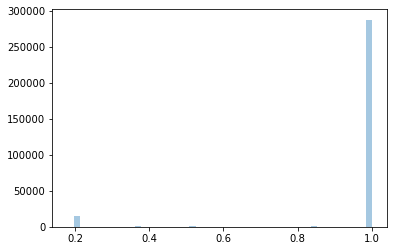

In [14]:
filtered_df = filtering_rows(train, threshold=0.9)

## Typage des données

In [15]:
train.describe()

,EXT_SOURCE_2,client_installments_AMT_PAYMENT_min_sum,DAYS_BIRTH,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_REGISTRATION,previous_loans_CNT_PAYMENT_mean,client_cash_CNT_INSTALMENT_FUTURE_min_max,CODE_GENDER_F,DAYS_LAST_PHONE_CHANGE,previous_loans_NAME_CONTRACT_STATUS_Refused_count_norm,REGION_POPULATION_RELATIVE,client_cash_SK_DPD_DEF_sum_max,client_installments_DAYS_INSTALMENT_max_max,client_cash_CNT_INSTALMENT_max_mean,client_cash_CNT_INSTALMENT_FUTURE_min_mean,client_installments_AMT_PAYMENT_max_min,client_installments_AMT_INSTALMENT_max_max,client_installments_NUM_INSTALMENT_VERSION_mean_max,client_installments_AMT_INSTALMENT_min_min,previous_loans_RATE_DOWN_PAYMENT_sum,previous_loans_SELLERPLACE_AREA_max,client_installments_AMT_PAYMENT_sum_mean,previous_loans_PRODUCT_COMBINATION_Cash X-Sell: low_count_norm,previous_loans_NAME_YIELD_GROUP_high_count_norm,previous_loans_DAYS_DECISION_mean,previous_loans_CNT_PAYMENT_max,NAME_EDUCATION_TYPE_Higher education,previous_loans_DAYS_LAST_DUE_1ST_VERSION_max,AMT_INCOME_TOTAL,client_cash_CNT_INSTALMENT_max_max,previous_loans_CNT_PAYMENT_sum,client_installments_DAYS_INSTALMENT_min_max,previous_loans_NAME_YIELD_GROUP_low_action_count_norm,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_max_mean,client_installments_NUM_INSTALMENT_VERSION_max_mean,previous_loans_HOUR_APPR_PROCESS_START_mean,NAME_FAMILY_STATUS_Married,client_installments_AMT_INSTALMENT_min_mean,previous_loans_NAME_CONTRACT_STATUS_Approved_count_norm,client_installments_NUM_INSTALMENT_NUMBER_max_mean,client_installments_AMT_PAYMENT_mean_sum,previous_loans_DAYS_DECISION_sum,client_installments_AMT_PAYMENT_max_mean,previous_loans_DAYS_FIRST_DUE_min,client_installments_DAYS_ENTRY_PAYMENT_max_min,client_installments_DAYS_ENTRY_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_mean_mean,client_cash_MONTHS_BALANCE_sum_max,client_installments_AMT_INSTALMENT_min_max,previous_loans_PRODUCT_COMBINATION_Cash X-Sell: high_count_norm,REGION_RATING_CLIENT,NAME_CONTRACT_TYPE_Cash loans,previous_loans_AMT_ANNUITY_mean,client_installments_AMT_PAYMENT_sum_min,previous_loans_DAYS_DECISION_max,previous_loans_NAME_YIELD_GROUP_low_normal_count_norm,client_installments_AMT_PAYMENT_max_sum,client_cash_NAME_CONTRACT_STATUS_Active_count_norm_mean,previous_loans_AMT_ANNUITY_min,previous_loans_SELLERPLACE_AREA_min,client_installments_DAYS_ENTRY_PAYMENT_min_sum,DEF_60_CNT_SOCIAL_CIRCLE,client_installments_AMT_INSTALMENT_sum_sum,client_installments_AMT_INSTALMENT_mean_min,previous_loans_DAYS_LAST_DUE_sum,previous_loans_NAME_PRODUCT_TYPE_walk-in_count_norm,client_cash_CNT_INSTALMENT_min_mean,previous_loans_AMT_GOODS_PRICE_min,client_installments_NUM_INSTALMENT_VERSION_sum_mean,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_INSTALMENT_mean_max,previous_loans_DAYS_LAST_DUE_1ST_VERSION_min,client_cash_CNT_INSTALMENT_FUTURE_min_sum,client_cash_CNT_INSTALMENT_mean_min,client_cash_SK_DPD_max_sum,FLAG_DOCUMENT_3,client_cash_counts_mean,previous_loans_NAME_CLIENT_TYPE_Refreshed_count_norm,previous_loans_DAYS_FIRST_DUE_mean,previous_loans_AMT_ANNUITY_max,HOUR_APPR_PROCESS_START,previous_loans_PRODUCT_COMBINATION_Cash Street: low_count_norm,previous_loans_NAME_PRODUCT_TYPE_XNA_count_norm,previous_loans_NAME_PORTFOLIO_POS_count_norm,client_cash_NAME_CONTRACT_STATUS_Completed_count_norm_mean,DEF_30_CNT_SOCIAL_CIRCLE,client_cash_counts_sum,previous_loans_NAME_TYPE_SUITE_Unaccompanied_count_norm,previous_loans_DAYS_TERMINATION_min,previous_loans_PRODUCT_COMBINATION_POS industry with interest_count_norm,previous_loans_AMT_CREDIT_min,previous_loans_WEEKDAY_APPR_PROCESS_START_SUNDAY_count_norm,previous_loans_AMT_APPLICATION_max,NAME_INCOME_TYPE_Working,client_cash_CNT_INSTALMENT_sum_min,NAME_EDUCATION_TYPE_Secondary / secondary special,ORGANIZATION_TYPE_Self-employed,client_installments_NUM_INSTALMENT_VERSION_sum_max,previous_loans_CHANNEL_TYPE_Channel of corporate sales_count_norm,previous_loans_DAYS_FIRST_DUE_sum,FLAG

In [16]:
train.dtypes

EXT_SOURCE_2                                                                    float64
client_installments_AMT_PAYMENT_min_sum                                         float64
DAYS_BIRTH                                                                        int64
AMT_CREDIT                                                                      float64
AMT_ANNUITY                                                                     float64
DAYS_EMPLOYED                                                                     int64
DAYS_ID_PUBLISH                                                                   int64
DAYS_REGISTRATION                                                               float64
previous_loans_CNT_PAYMENT_mean                                                 float64
client_cash_CNT_INSTALMENT_FUTURE_min_max                                       float64
CODE_GENDER_F                                                                     int64
DAYS_LAST_PHONE_CHANGE          

## Équilibre des classes

In [17]:
def categorical_distribution(dataframe, feature, ordinal=False):
    """Function plotting the bar-plot and pie-plot (as subplots) for 
    a distribution of categorical features."""
    
    # importing libraries
    import matplotlib.pyplot as plt

    # filtering non-null data for the feature
    mask = dataframe[feature].notnull()
    data_view = dataframe[mask]
    
    # Setting the data to plot
    x=data_view[feature]
    
    # Set frequencies and labels, sorting by index
    if ordinal==True:
        labels = list(x.value_counts().sort_index().index.astype(str))
        frequencies = x.value_counts().sort_index()
    else:
        labels = list(x.value_counts().sort_values(ascending=False).index.astype(str))
        frequencies = x.value_counts().sort_values(ascending=False)
    
    # Graphical properties of the main figure
    fig = plt.figure(figsize=(14, 6))
    
    plt.suptitle("Empiric statistical distribution: " + feature, fontsize=25)
    
    # Main graphical properties of the first subplot (histogram)
    ax1 = plt.subplot(121)
    ax1.set_xlabel("Values", fontsize=20)
    ax1.set_ylabel("Frequencies", fontsize=20)
    ax1.set_xticklabels(labels, rotation='45', horizontalalignment="right")

    # Main graphical properties of the second subplot (pieplot)
    ax2 = plt.subplot(122)
    ax2.set_xlabel("Relative frequencies", fontsize=20)
    
    # plotting the plots
    ax1.bar(labels, frequencies)
    ax2.pie(frequencies,
            autopct='%1.2f%%',
            shadow=True,
              )
    
    ax2.legend(labels)
    plt.show()
    return fig

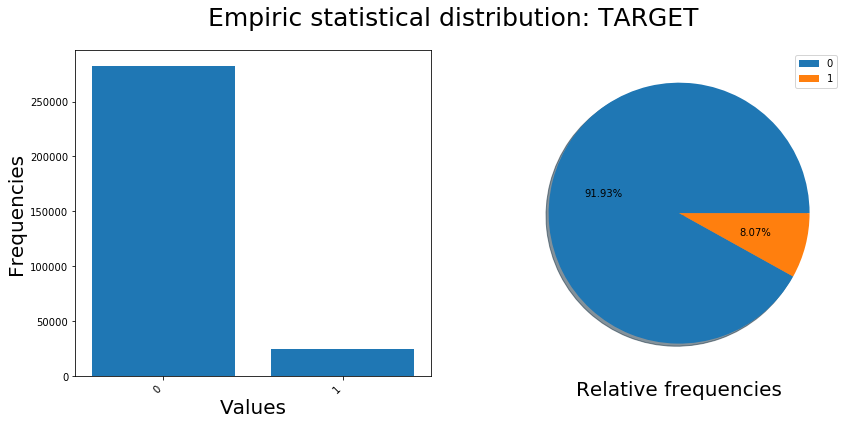

In [18]:
fig = categorical_distribution(
    train,
    'TARGET'
)

fig.savefig('plots/imba_classes.png')

# **ÉQUILIBRAGE DES CLASSES**

In [19]:
# Set random integer (seed) - 891
from random import randrange
seed = randrange(1000)
print("Seed value: ", seed)

Seed value:  830


## **Sur-échantillonnage** (*upsampling*) de la classe minoritaire

In [20]:
# DO NOT support missing data
# ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

from collections import Counter
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=0)

# X = train.drop(columns='TARGET')
# y = train['TARGET']

print(sorted(Counter(y).items()))

# SMOTE (oversampling) and Edited Nearest Neighbours (downsampling)
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=seed)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))



# SMOTE (oversampling) and Tomek’s links (downsampling)
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=seed)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0, 64), (1, 262), (2, 4674)]
[(0, 4069), (1, 4388), (2, 3534)]
[(0, 4518), (1, 4585), (2, 4451)]


## **Sous-échantillonnage** (*downsampling*) de la classe majoritaire

In [21]:
def downsampling(df, target_feature='TARGET'):

    from sklearn.utils import resample
    
    # Getting the majority class
    majority_class = df[target_feature].value_counts(sort=True).index[0]
    
    # Create a mask for the majority class
    mask = df[target_feature] == majority_class
    
    # Get the subset of the majority and minority classes
    maj_df = df[mask]
    min_df = df[~mask]
    
    # Downsampling the majority class
    df_maj_downsampled = resample(
        maj_df,
        replace=False,
        n_samples=len(min_df),
        random_state=seed,
    )
    
    # Concatenation of the DataFrames for the 2 classes
    df_downsampled = pd.concat([min_df, df_maj_downsampled])

    return df_downsampled

train = downsampling(
    df=train,
    target_feature='TARGET'
)

train['TARGET'].value_counts()

1    24825
0    24825
Name: TARGET, dtype: int64

# **PRÉPARATION**

## Échantillonnage pour la sélection du modèle

In [22]:
# Sampling
train_sample = train.sample(n=5000, random_state=seed)

## Séparation des variables explicatives et des cibles

In [23]:
# Features' matrix and sampling
X =  train_sample.drop(columns=["TARGET"])
display(X.head())

# Target vector
y = train_sample['TARGET']

,EXT_SOURCE_2,client_installments_AMT_PAYMENT_min_sum,DAYS_BIRTH,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_REGISTRATION,previous_loans_CNT_PAYMENT_mean,client_cash_CNT_INSTALMENT_FUTURE_min_max,CODE_GENDER_F,DAYS_LAST_PHONE_CHANGE,previous_loans_NAME_CONTRACT_STATUS_Refused_count_norm,REGION_POPULATION_RELATIVE,client_cash_SK_DPD_DEF_sum_max,client_installments_DAYS_INSTALMENT_max_max,client_cash_CNT_INSTALMENT_max_mean,client_cash_CNT_INSTALMENT_FUTURE_min_mean,client_installments_AMT_PAYMENT_max_min,client_installments_AMT_INSTALMENT_max_max,client_installments_NUM_INSTALMENT_VERSION_mean_max,client_installments_AMT_INSTALMENT_min_min,previous_loans_RATE_DOWN_PAYMENT_sum,previous_loans_SELLERPLACE_AREA_max,client_installments_AMT_PAYMENT_sum_mean,previous_loans_PRODUCT_COMBINATION_Cash X-Sell: low_count_norm,previous_loans_NAME_YIELD_GROUP_high_count_norm,previous_loans_DAYS_DECISION_mean,previous_loans_CNT_PAYMENT_max,NAME_EDUCATION_TYPE_Higher education,previous_loans_DAYS_LAST_DUE_1ST_VERSION_max,AMT_INCOME_TOTAL,client_cash_CNT_INSTALMENT_max_max,previous_loans_CNT_PAYMENT_sum,client_installments_DAYS_INSTALMENT_min_max,previous_loans_NAME_YIELD_GROUP_low_action_count_norm,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_max_mean,client_installments_NUM_INSTALMENT_VERSION_max_mean,previous_loans_HOUR_APPR_PROCESS_START_mean,NAME_FAMILY_STATUS_Married,client_installments_AMT_INSTALMENT_min_mean,previous_loans_NAME_CONTRACT_STATUS_Approved_count_norm,client_installments_NUM_INSTALMENT_NUMBER_max_mean,client_installments_AMT_PAYMENT_mean_sum,previous_loans_DAYS_DECISION_sum,client_installments_AMT_PAYMENT_max_mean,previous_loans_DAYS_FIRST_DUE_min,client_installments_DAYS_ENTRY_PAYMENT_max_min,client_installments_DAYS_ENTRY_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_mean_mean,client_cash_MONTHS_BALANCE_sum_max,client_installments_AMT_INSTALMENT_min_max,previous_loans_PRODUCT_COMBINATION_Cash X-Sell: high_count_norm,REGION_RATING_CLIENT,NAME_CONTRACT_TYPE_Cash loans,previous_loans_AMT_ANNUITY_mean,client_installments_AMT_PAYMENT_sum_min,previous_loans_DAYS_DECISION_max,previous_loans_NAME_YIELD_GROUP_low_normal_count_norm,client_installments_AMT_PAYMENT_max_sum,client_cash_NAME_CONTRACT_STATUS_Active_count_norm_mean,previous_loans_AMT_ANNUITY_min,previous_loans_SELLERPLACE_AREA_min,client_installments_DAYS_ENTRY_PAYMENT_min_sum,DEF_60_CNT_SOCIAL_CIRCLE,client_installments_AMT_INSTALMENT_sum_sum,client_installments_AMT_INSTALMENT_mean_min,previous_loans_DAYS_LAST_DUE_sum,previous_loans_NAME_PRODUCT_TYPE_walk-in_count_norm,client_cash_CNT_INSTALMENT_min_mean,previous_loans_AMT_GOODS_PRICE_min,client_installments_NUM_INSTALMENT_VERSION_sum_mean,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_INSTALMENT_mean_max,previous_loans_DAYS_LAST_DUE_1ST_VERSION_min,client_cash_CNT_INSTALMENT_FUTURE_min_sum,client_cash_CNT_INSTALMENT_mean_min,client_cash_SK_DPD_max_sum,FLAG_DOCUMENT_3,client_cash_counts_mean,previous_loans_NAME_CLIENT_TYPE_Refreshed_count_norm,previous_loans_DAYS_FIRST_DUE_mean,previous_loans_AMT_ANNUITY_max,HOUR_APPR_PROCESS_START,previous_loans_PRODUCT_COMBINATION_Cash Street: low_count_norm,previous_loans_NAME_PRODUCT_TYPE_XNA_count_norm,previous_loans_NAME_PORTFOLIO_POS_count_norm,client_cash_NAME_CONTRACT_STATUS_Completed_count_norm_mean,DEF_30_CNT_SOCIAL_CIRCLE,client_cash_counts_sum,previous_loans_NAME_TYPE_SUITE_Unaccompanied_count_norm,previous_loans_DAYS_TERMINATION_min,previous_loans_PRODUCT_COMBINATION_POS industry with interest_count_norm,previous_loans_AMT_CREDIT_min,previous_loans_WEEKDAY_APPR_PROCESS_START_SUNDAY_count_norm,previous_loans_AMT_APPLICATION_max,NAME_INCOME_TYPE_Working,client_cash_CNT_INSTALMENT_sum_min,NAME_EDUCATION_TYPE_Secondary / secondary special,ORGANIZATION_TYPE_Self-employed,client_installments_NUM_INSTALMENT_VERSION_sum_max,previous_loans_CHANNEL_TYPE_Channel of corporate sales_count_norm,previous_loans_DAYS_FIRST_DUE_sum,FLAG

## Séparation (stratifiée) du jeu d'entraînement et du du jeu de test

In [24]:
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
        X,
        y,
        train_size=0.8,
        test_size=0.2,
        random_state=seed,
        stratify=y, # because classes are imbalanced
    )

## Imputations

In [25]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(X_train)

feature_names = X_train.columns

X_train = pd.DataFrame(imp_mean.transform(X_train), columns=feature_names)
X_test = pd.DataFrame(imp_mean.transform(X_test), columns=feature_names)

In [26]:
columns_filling_rate(X_train, columns='all', missing_only=True)
columns_filling_rate(X_test, columns='all', missing_only=True)

No missing value.
No missing value.


## Création d'un **modèle naïf** (*baseline*)

In [27]:
from sklearn.dummy import DummyClassifier

# Creating the naïve baseline model
model = DummyClassifier(strategy='stratified', random_state=seed)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Score of the naïve model: mean accuracy = {:.4f}".format(score))

Score of the naïve model: mean accuracy = 0.5040


## Choix de la **métrique**


In [28]:
from sklearn.metrics import roc_auc_score

score = roc_auc_score(y_test, model.predict(X_test))
print("Score of the naïve model: AUC = {:.4f}".format(score))

Score of the naïve model: AUC = 0.5040


# **SÉLECTION DU PIPE-LINE** (*hyperopt*)

In [29]:
from hyperopt import hp

# Initializing the search space
space = {}

## Définition de l'espace des **pré-traitements**

In [30]:
# Initializing the search space for preprocessing steps
space['preprocessing_steps'] = {
    'scale':       hp.choice('scale', [True, False]),
    'normalize':       hp.choice('normalize', [True, False]),
}

In [31]:
# Define the preprocessing steps
def preprocess_steps(params, X_):
    from sklearn.preprocessing import Normalizer
    from sklearn.preprocessing import StandardScaler
    
    # print(params)
    
    if 'normalize' in params['preprocessing_steps']:
        if params['preprocessing_steps']['normalize'] == True:
            X_ = Normalizer().fit_transform(X_)
        
    if 'scale' in params['preprocessing_steps']:
        if params['preprocessing_steps']['scale'] == True:
            X_ = StandardScaler().fit_transform(X_)

    return X_

## Définition de l'espace des **modèles**


In [32]:
# Loading libraries
from hyperopt import hp

# Initalisation of the spaces of research for models
models_spaces = {}

In [33]:
from sklearn.naive_bayes import GaussianNB

### NAIVE BAYES
models_spaces['naive_bayes'] = {
    'model': GaussianNB,
}

In [34]:
from sklearn.svm import SVC

### SVM
models_spaces['svm'] = {
    'model':     SVC,
    'C':         hp.uniform('svm_C', 0, 20),
    'kernel':    hp.choice('svm_kernel', ['linear', 'sigmoid', 'poly', 'rbf']),
    'gamma':     hp.uniform('svm_gamma', 0, 20),
    'probability': True,
}

In [35]:
from sklearn.ensemble.forest import RandomForestClassifier

### RANDOM FOREST
models_spaces['rf'] = { 
    'model':        RandomForestClassifier,
    'max_depth':    hp.choice('rf_max_depth', range(1,20)),
    'max_features': hp.choice('rf_max_features', range(1,3)),
    'n_estimators': hp.choice('rf_n_estimators', range(10,50)),
    'criterion':    hp.choice('rf_criterion', ["gini", "entropy"]),
}

In [36]:
from sklearn.linear_model import LogisticRegression

### LOGISTIC REGRESSION
models_spaces['logit'] = { 
    'model':          LogisticRegression,
    'warm_start' :    hp.choice('logit_warm_start', [True, False]),
    'fit_intercept' : hp.choice('logit_fit_intercept', [True, False]),
    'tol' :           hp.uniform('logit_tol', 0.00001, 0.0001),
    'C' :             hp.uniform('logit_C', 0.05, 3),
    'solver' :        hp.choice('logit_solver', ['newton-cg', 'lbfgs', 'liblinear']),
    'max_iter' :      hp.choice('logit_max_iter', range(100,1000)),
    'multi_class' :   'auto',
    'class_weight' :  'balanced',
}

In [37]:
from sklearn.neighbors import KNeighborsClassifier

### k-NEAREST NEIGHBORS
models_spaces['knn'] = {
    'model': KNeighborsClassifier,
    'n_neighbors': hp.choice('knn_n_neighbors', range(1,100)),
}

In [38]:
# Creating the whole space from all the model-specific spaces
space['models_spaces'] = hp.choice(
        'models_spaces',
        [ models_spaces[key] for key in models_spaces ]
    )

## Définition de la **métrique de sélection**


### **Métrique** personnalisée

In [39]:
from sklearn.metrics import confusion_matrix

def custom_scorer(model, X, y_true):

    def custom_score(y_true, y_pred):
        # Relative loss and gains for each case
        TP_value = 1
        TN_value = 0
        FP_value = 0
        FN_value = -3

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # True Positive, False Positive, False Negative, True Negative
        TP = cm[0][0]
        FP = cm[0][1]
        FN = cm[1][0]
        TN = cm[1][1]

        # Full negative and positive cases
        N = TN + FN
        P = TP + FP

        gain = TP*TP_value + TN*TN_value + FP*FP_value + FN*FN_value
        best = P*TP_value + N*TN_value
        worst = P*FN_value + N*FP_value
        # normalize to get score between 0 and 1
        score = (gain - worst) / (best - worst)
        return score

    def predict_threshold(model, X, threshold=0.5):
        predictions = model.predict_proba(X)
        mask = (predictions[:, 1] > threshold)
        return mask.astype(int)
    
    scores = []
    for threshold in np.linspace(0, 1, num=101):
        y_pred = predict_threshold(model, X_train, threshold=threshold)
        score = custom_score(y_train, y_pred)
        scores.append(score)
    
    return max(scores)

### **Générateur de plis**

In [40]:
from sklearn.model_selection import KFold

# Define the cross-validation generator
cv_inner = KFold(
    n_splits=3, # number of folds (default=5)
    shuffle=True, # shuffle the data before splitting into batche
    random_state=seed, # seeding the random number generator for shuffling
)

### **Validation croisée**

In [41]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

# Define the loss metric for the model
def get_acc_status(clf, X_, y):
    
    # Proceed to the cross-validation
    # cv_result is a dict : test_score, train_score, fit_time, score_time, estimator
    cv_results = cross_validate(
        clf,
        X_,
        y,
        cv=cv_inner,
        scoring=custom_scorer,
    )

    return {
        'loss': -cv_results['test_score'].mean(),
        'loss_std': cv_results['test_score'].std(),
        'status': STATUS_OK,
    }

## Définition de la "**fonction objectif**" d'*Hyperopt*

In [42]:
# Define th objective function
def obj_fnc(params):
    
        # print(params)
    
        # proceed to preprocessing
        X_train_ = preprocess_steps(params, X_train[:])
        
        # get all parameters, except the model
        parameters = params['models_spaces'].copy()
        del parameters['model']
        
        # instanciation of the classifier model with parameters
        clf = params['models_spaces']['model'](**parameters)
        
        # return loss and status
        return(get_acc_status(clf, X_train_, y_train))

## Définition de la **recherche**

In [43]:
# load libraries
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK, space_eval
import pickle

def run_trials():

    trials_step = 1  # how many additional trials to do after loading saved trials. 1 = save after iteration
    initial_evals = 1  # initial max_trials. put something small to not have to wait

    
    try:  # try to load an already saved trials object, and increase the max
        hypopt_trials = pickle.load(open("hp_trials/trials.hyperopt", "rb"))
        print("Found saved Trials! Loading...")
        max_evals = len(hypopt_trials.trials) + trials_step
        print("Rerunning from {} trials.".format(len(hypopt_trials.trials)))
        
    except:  # create a new trials object and start searching
        print("Unable to load previous trials...")
        hypopt_trials = Trials()
        max_evals = initial_evals

    # Optimisation accross the search space
    global best_params
    best_params = fmin(
        obj_fnc,
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=hypopt_trials
    )

    # save the trials object
    with open("hp_trials/trials.hyperopt", mode="wb") as f:
        pickle.dump(hypopt_trials, f)
        
    # get the best_params
    best_params = space_eval(space, best_params)
    
    # print the main results
    print(
        "\n----------------------",
        "\nAlgo:", best_params['models_spaces']['model'],
        "\nLoss:", hypopt_trials.best_trial['result']['loss'],
        "\nPreprocessing:", best_params['preprocessing_steps'],
        "\nModel params:", best_params['models_spaces'],
    )

## Exécution de la **recherche** (persistante)

In [ ]:
import threading as th
import keyboard

# loop indefinitely and stop whenever you like (pressing ENTER)
keep_going = True
def key_capture_thread():
    global keep_going
    # Blocks until you press 'ESC'.
    keyboard.wait('esc')
    keep_going = False
    print('\nInterrupting… Please wait until shut down.')

def trials_loop():
    th.Thread(target=key_capture_thread, args=(), name='key_capture_thread', daemon=True).start()
    while keep_going:
        print("\nExecuting... Press 'ESC' key to interrupt.")
        run_trials()

    print('\nSuccessfully interrupted!')

trials_loop()


Executing... Press 'ESC' key to interrupt.
Found saved Trials! Loading...
Rerunning from 30 trials.
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

# **RÉCUPÉRATION DU PIPE-LINE** (optimisé)

## **Récupération** des meilleurs hyper-paramètres

In [ ]:
best_params

## **Reconstruction** du pipeline de pré-traitement

In [ ]:
def define_preprocessor(X):

    # Load libraries
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import Normalizer
    from sklearn.preprocessing import StandardScaler
    
    # Initializing the list of preprocessing steps
    preprocessing_steps = []
    
    if 'normalize' in best_params['preprocessing_steps']:
        if best_params['preprocessing_steps']['normalize'] == True:
            # add the normalisation step to the preprocessing steps
            preprocessing_steps.append(('normalize', Normalizer()))
        # remove the normalization from the list of best_params
        # del best_params['normalize']
    
    if 'scale' in best_params['preprocessing_steps']:
        if best_params['preprocessing_steps']['scale'] == True:
            # add the scaling step to the preprocessing steps
            preprocessing_steps.append(('scale', StandardScaler()))
        # remove the normalization from the list of best_params
        # del best_params['scale']
    
    # Creating the preprocessing pipeline
    if len(preprocessing_steps) != 0:
        # if some processing
        preprocessor = Pipeline(
            steps=preprocessing_steps
        )
    else:
        # if no processing step
        preprocessor = Pipeline(
            steps=[('passthrough', None)]
        )
    
    return preprocessor

preprocessor = define_preprocessor(X_train)

## **Reconstruction** du pipeline complet

In [ ]:
def define_pipeline(preprocessor):

    # Load libraries
    from sklearn.pipeline import Pipeline
    
    # Get the model from parameters
    model = best_params['models_spaces'].pop('model')
    
    # Instanciate model with best parameters 
    classifier = model(**best_params['models_spaces'])
    
    # Create a pipeline
    pipe = Pipeline([
        ("preprocess", preprocessor), # preprocessing steps
        ("classifier", classifier), # modelisation
        ])
    
    # Return pipeline
    return pipe

In [ ]:
best_params

In [ ]:
pipe = define_pipeline(preprocessor)
pipe.fit(X_train, y_train)

## **Évaluation finale** du meilleur modèle

In [ ]:
from sklearn.metrics import roc_auc_score

# get predicted probas for positive label
y_train_probas = pipe.predict_proba(X_train)[:,1]
score_train = roc_auc_score(y_train, y_train_probas)
print("Score of the best model on the train set: AUC = {:.3f}".format(score_train))

y_test_probas = pipe.predict_proba(X_test)[:,1]
score_test = roc_auc_score(y_test, y_test_probas)
print("Score of the best model on the test set: AUC = {:.3f}".format(score_test))

## Définition d'une **métrique** métier

### Confusion matrix

In [ ]:
from yellowbrick.classifier import ConfusionMatrix

mapping = {0:"Non-default", 1:"Default"}

fig, ax = plt.subplots(figsize=(6, 6))

cm_viz = ConfusionMatrix(
    pipe,
    classes=["Non-default", "Default"],
    label_encoder=mapping,
)
cm_viz.score(X_train, y_train)
cm_viz.poof()

In [ ]:
%%capture --no-display
from yellowbrick.classifier import DiscriminationThreshold

fig, ax = plt.subplots(figsize=(6, 5))
dt_viz = DiscriminationThreshold(pipe)
dt_viz.fit(X_train, y_train)
dt_viz.poof()

fig.savefig("plots/discr_threshold.png", dpi=300)

In [ ]:
    from sklearn.metrics import confusion_matrix


    def custom_score(y_true, y_pred):
        # Relative loss and gains for each case
        TP_value = 1
        TN_value = 0
        FP_value = 0
        FN_value = -3

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # True Positive, False Positive, False Negative, True Negative
        TP = cm[0][0]
        FP = cm[0][1]
        FN = cm[1][0]
        TN = cm[1][1]

        # Full negative and positive cases
        N = TN + FN
        P = TP + FP

        gain = TP*TP_value + TN*TN_value + FP*FP_value + FN*FN_value
        best = P*TP_value + N*TN_value
        worst = P*FN_value + N*FP_value
        # normalize to get score between 0 and 1
        score = (gain - worst) / (best - worst)
        return score

    def predict_threshold(model, X, threshold=0.5):
        predictions = model.predict_proba(X)
        mask = (predictions[:, 1] > threshold)
        return mask.astype(int)
    

In [ ]:
import numpy

scores = []
for threshold in np.linspace(0, 1, num=101):
    y_pred = predict_threshold(pipe, X_train, threshold=threshold)
    score = custom_score(y_train, y_pred)
    scores.append(score)

plt.plot(np.linspace(0, 1, num=101), scores)

max_score = max(scores)
opt_threshold = np.linspace(0, 1, num=101)[scores.index(max_score)]

print("Max score:", max_score)
print("Optimal threshold:", opt_threshold)

# **Sauvegarde du modèle**
Nous ré-entraînons le modèle avec les les hyperparamètres sélectionnés, sur l'ensemble du jeu de données pour lequel nous disposons des étiquettes cibles : le jeu de données d'entraînement et le jeu de données de test.

Nous sauvegardons le modèle dans un fichier pickle pour usage ultérieur, en indiquant dans le nom du fichier la version de scikit-learn.

## Ré-entraînement final sur l'ensemble du jeu de données étiquetté

In [ ]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(X)
X = pd.DataFrame(imp_mean.transform(X), columns=feature_names)

columns_filling_rate(X, columns='all', missing_only=True)

In [ ]:
# Load libraries
import sklearn
import joblib

# Re-training the final model on the whole set
pipe.fit(X, y)

# Get scikit-learn version
scikit_version = sklearn.__version__

# Save the models for GHG and SiteEnergyUse as pickle files
joblib.dump(model, "models/model_{version}.pkl".format(version=scikit_version))

# Hyperopt amélioré

## Définition des **étapes de prétraitement**


# TODO

* Nettoyage-exploration
    * downsampling et oversampling (dupliquer, exemples synthetiques SMOTE)
    * étude des corrélations (non-numériques)
    * SK_ID : mettre en index…
    * missing_no : librairie valeurs manquantes
    
    
* Modélisation de la probabilité de défaut de paiement
    * choix d'une métrique métier adaptée : accuracy, F1, precision, recall, roc curve, AUC, matrice de confusion
    * utilisation de la librairie hyperopt-sklearn (essayer davantage)
    * models :
        * SVM, 
        * Naive Bayes,
        * régression logistique,
        * Supersparse Linear Integer Model (SLIM),
        * Lasso
    * calibration (Naive Bayes)
    * métrique métier personnalisée (fonction de perte / métrique), avec 2 paramètres :
        * coût d'un faux positif : prêt qui fait défaut
        * coût d'un faux négatif : refus de prêt qui n'aurait pas fait défaut
        * gain d'un vrai négatif : prêt qui ne fait pas défaut
        * gain d'un vrai positif : refus de prêt qui aurait fait défaut
    * Aide à la décision : prêter ou pas prêter ?
    * Pondération des poids de chaque classe (pénalisation) pour prendre en compte l'asymétrie
    * LaTeX pour custom score
    * Hyperopt : sauvegarde après chaque itération…
    

* Dashboard interactif (streamlit)
    * liste des clients (mise en cache)
    * ajouter les descriptifs des données personnelles (d'origine) (mise en cache) 
    * probabilité de défaut de paiement (au lieu de 'score')
    * data perso : largeur page
    * Laisser les entêtes… + bouton pour développer ?
    * comparaison à des groupes de client similaires
        * aggrégation sur serveur (cache) de tous les clients
        * aggrégation sur serveur (cache) des 100 clients ayant un score analogue
        * affichage des données de quelques clients ayant un profil similaire (+ target)
    * interprétabilité
        * SHAP
        * Surogate model à défaut
    * affichages graphe (st.write)


* Interprétabilité :
    * LIME
    * SHAP
    * Surrogate model (modèle substitut) + tree interpretation (treeinterpreter package)
        * Tester avec un regressor

* Création d'une note méthodologique sur l'interprétabilité
    * pourcentages
    * complexité (training, testing)
    * features importance : positives et négatives
    * limites du modèle :
        * compromis précision-interprétabilité
        * interprétabilité modèle != interprétabilités prédiction

# Questions

* Comparaison aux profils similaires : clustering ou kNN ?

* Kernel Kaggle : faut-il faire sur Kaggle ? Comment faire un export Jupyter ?

* Discrimination threshold : à partir de quel score refuser le crédit ?

* Lien entre fonction de perte, métrique de sélection du modèle et optimisation du seuillage…

* Intégration JavaScript (Shap) dans dashboard (Streamlit)